#  Predictive Maintenance of Wind Turbine Gearbox Using SCADA Time-Series Data

---

## 1.  Business Understanding

### Objective
The goal of this project is to develop a machine learning model capable of predicting gearbox failures in a utility-scale wind turbine using SCADA time-series data.

### Business Motivation
Gearbox failures are among the most expensive and maintenance-intensive issues in wind turbines. Early detection of degradation patterns allows operators to:
- Reduce unplanned downtime
- Optimize maintenance scheduling
- Lower operational costs
- Increase turbine lifetime

### Research Question
Can gearbox failures be predicted in advance using temperature, vibration, pressure, and oil condition data?

---

## 2.  Data Understanding

### Dataset Description
The dataset contains 5 years of high-resolution SCADA data recorded at 10-minute intervals. The labeled version includes a target variable indicating the operational state or failure mode.

### Key Variables
- **timestamp** – time of measurement
- **gearbox_oil_temp** – lubrication oil temperature (°C)
- **gearbox_bearing_temp** – bearing temperature (°C)
- **vibration_x, vibration_y, vibration_z** – vibration levels
- **oil_pressure** – lubrication system pressure (bar)
- **particle_count** – metallic debris concentration
- **is_anomaly** – operational state / failure indicator

### Initial Exploration
- [ ] Check class distribution
- [ ] Visualize time trends
- [ ] Inspect correlations
- [ ] Identify seasonality and degradation trends

---

## 3. 🧹 Data Preparation

### Cleaning and Formatting
- [ ] Convert timestamp to datetime
- [ ] Sort chronologically
- [ ] Handle missing values (if any)
- [ ] Remove duplicates

### Feature Engineering
- [ ] Extract time-based features (hour, month)
- [ ] Create rolling statistics:
  - Rolling mean (1h, 6h, 24h)
  - Rolling standard deviation
- [ ] Compute rate of change for:
  - Vibration
  - Temperature
- [ ] Aggregate vibration magnitude

### Data Transformation
- [ ] Normalize or standardize features
- [ ] Encode labels if necessary
- [ ] Split dataset:
  - Train set
  - Validation set
  - Test set
  - *Time-aware splitting will be used to avoid data leakage*

---

## 4. Modeling

### Baseline Model
- [ ] Logistic Regression

### Advanced Models
- [ ] Random Forest
- [ ] Gradient Boosting (e.g., XGBoost)

### Training Strategy
- [ ] Time-series aware validation
- [ ] Hyperparameter tuning
- [ ] Cross-validation (if appropriate)

---

## 5.  Evaluation

### Evaluation Metrics
- [ ] Accuracy
- [ ] Precision
- [ ] Recall
- [ ] F1-score
- [ ] ROC-AUC

### Additional Analysis
- [ ] Confusion Matrix
- [ ] Feature Importance
- [ ] False Positive vs False Negative impact

*Special focus will be given to recall for failure detection to minimize missed failures.*

---

## 6.  Deployment

### Practical Application
The model could be integrated into an SCADA monitoring system to:
- Generate early warnings
- Support maintenance planning
- Reduce emergency repairs

### Business Impact
- Increased reliability
- Lower operational costs
- Improved asset management

### Expected Outcome
The project aims to demonstrate that gearbox failures can be predicted using sensor-based time-series data and that certain features (e.g., vibration growth and temperature increase) act as early indicators of degradation.

---

## Initial Data Analysis


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Load the labeled dataset
df = pd.read_csv('data/turbine_5yr_labeled_data.csv')

print(df.dtypes)


timestamp                   str
gearbox_oil_temp        float64
gearbox_bearing_temp    float64
vibration_x             float64
vibration_y             float64
vibration_z             float64
oil_pressure            float64
particle_count            int64
is_anomaly                int64
dtype: object


### 1. Basic Statistical Summary


In [15]:
print(df.describe())

print("\n" + "=" * 60)
missing = df.isnull().sum()
if missing.sum() == 0:
    print("✓ No missing values found!")
else:
    print(missing[missing > 0])

duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


       gearbox_oil_temp  gearbox_bearing_temp    vibration_x    vibration_y  \
count     262800.000000         262800.000000  262800.000000  262800.000000   
mean          61.087639             68.188161       0.021638       0.019907   
std            7.538446              7.728958       0.005915       0.005442   
min           45.860000             52.190000       0.008800       0.008100   
25%           54.480000             61.440000       0.018900       0.017400   
50%           61.010000             68.060000       0.021100       0.019400   
75%           67.540000             74.660000       0.023300       0.021400   
max           89.990000             94.700000       0.085900       0.079000   

         vibration_z   oil_pressure  particle_count     is_anomaly  
count  262800.000000  262800.000000   262800.000000  262800.000000  
mean        0.024884       4.265352      915.571435       0.020928  
std         0.006803       0.133616      455.547212       0.143145  
min         

### 2. Target Variable Analysis (is_anomaly)


is_anomaly
0    257300
1      5500
Name: count, dtype: int64
is_anomaly
0    97.907154
1     2.092846
Name: proportion, dtype: float64


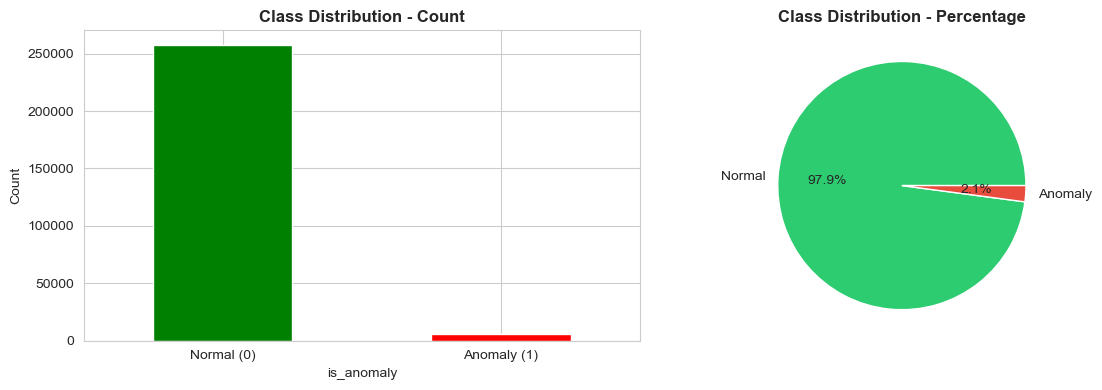


Class Imbalance Ratio: 1:46.8


In [16]:
class_dist = df['is_anomaly'].value_counts()
print(class_dist)
print(df['is_anomaly'].value_counts(normalize=True) * 100)

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
class_dist.plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Class Distribution - Count', fontsize=12, fontweight='bold')
axes[0].set_xlabel('is_anomaly')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Normal (0)', 'Anomaly (1)'], rotation=0)

# Pie chart
colors = ['#2ecc71', '#e74c3c']
df['is_anomaly'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%',
                                      colors=colors, labels=['Normal', 'Anomaly'])
axes[1].set_title('Class Distribution - Percentage', fontsize=12, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

print(f"\nClass Imbalance Ratio: 1:{class_dist[0]/class_dist[1]:.1f}")


### 3. Temporal Analysis



Date Range: 2025-01-01 00:00:00 to 2029-12-30 23:50:00
Duration: 1824 days
Time Interval: 10 minutes


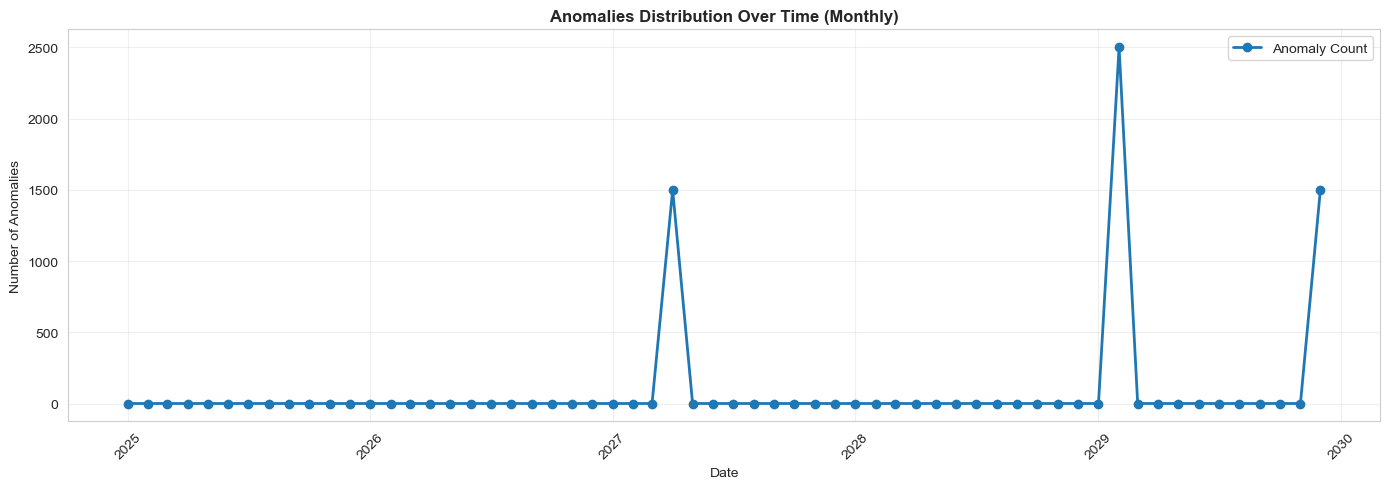

In [17]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"\nDate Range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Duration: {(df['timestamp'].max() - df['timestamp'].min()).days} days")
print(f"Time Interval: {(df['timestamp'].iloc[1] - df['timestamp'].iloc[0]).total_seconds() / 60:.0f} minutes")

# Anomalies over time
anomalies_by_month = df.groupby(df['timestamp'].dt.to_period('M'))['is_anomaly'].agg(['sum', 'count'])
anomalies_by_month.index = anomalies_by_month.index.to_timestamp()

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(anomalies_by_month.index, anomalies_by_month['sum'], label='Anomaly Count', marker='o', linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Anomalies')
ax.set_title('Anomalies Distribution Over Time (Monthly)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 4. Feature Analysis


In [18]:
feature_cols = ['gearbox_oil_temp', 'gearbox_bearing_temp', 'vibration_x',
                'vibration_y', 'vibration_z', 'oil_pressure', 'particle_count']

for feature in feature_cols:
    normal = df[df['is_anomaly'] == 0][feature]
    anomaly = df[df['is_anomaly'] == 1][feature]

    print(f"\n{feature}:")
    print(f"  Normal:  mean={normal.mean():.2f}, std={normal.std():.2f}, min={normal.min():.2f}, max={normal.max():.2f}")
    print(f"  Anomaly: mean={anomaly.mean():.2f}, std={anomaly.std():.2f}, min={anomaly.min():.2f}, max={anomaly.max():.2f}")



gearbox_oil_temp:
  Normal:  mean=60.87, std=7.34, min=45.86, max=76.28
  Anomaly: mean=71.05, std=9.62, min=56.07, max=89.99

gearbox_bearing_temp:
  Normal:  mean=67.83, std=7.38, min=52.19, max=85.58
  Anomaly: mean=84.84, std=5.11, min=71.90, max=94.70

vibration_x:
  Normal:  mean=0.02, std=0.00, min=0.01, max=0.03
  Anomaly: mean=0.05, std=0.02, min=0.01, max=0.09

vibration_y:
  Normal:  mean=0.02, std=0.00, min=0.01, max=0.03
  Anomaly: mean=0.05, std=0.02, min=0.01, max=0.08

vibration_z:
  Normal:  mean=0.02, std=0.00, min=0.01, max=0.04
  Anomaly: mean=0.06, std=0.02, min=0.02, max=0.10

oil_pressure:
  Normal:  mean=4.28, std=0.09, min=3.96, max=4.57
  Anomaly: mean=3.74, std=0.46, min=2.92, max=4.34

particle_count:
  Normal:  mean=918.81, std=452.21, min=120.00, max=1708.00
  Anomaly: mean=764.16, std=570.77, min=277.00, max=1698.00


### 5. Feature Distribution Comparison


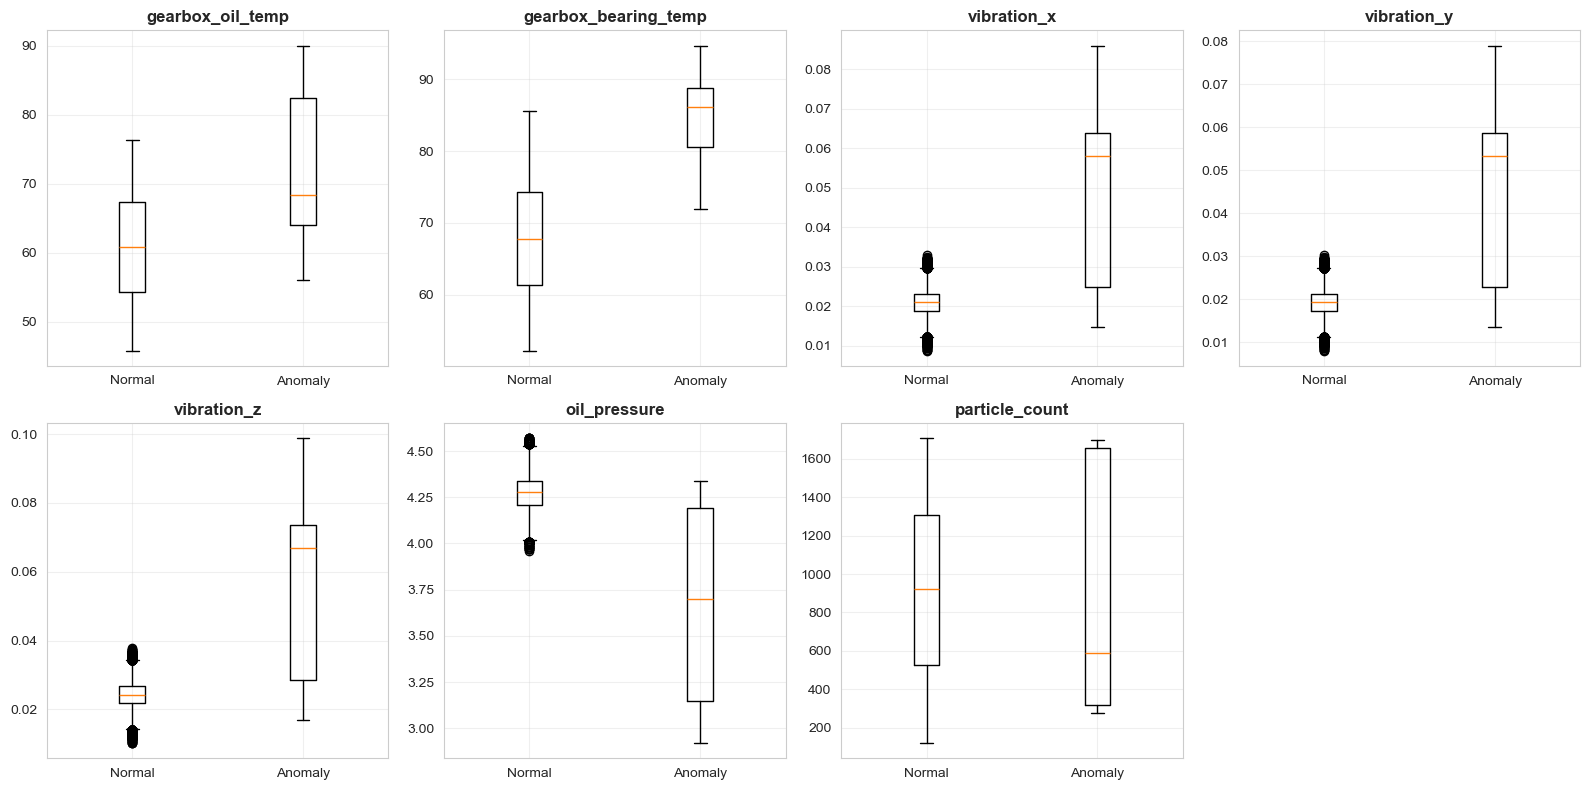

In [19]:
# Box plots for all features
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, feature in enumerate(feature_cols):
    data_to_plot = [df[df['is_anomaly'] == 0][feature],
                    df[df['is_anomaly'] == 1][feature]]
    axes[idx].boxplot(data_to_plot, labels=['Normal', 'Anomaly'])
    axes[idx].set_title(feature, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

# Hide the last empty subplot
axes[-1].set_visible(False)

plt.tight_layout()
plt.show()


### 6. Correlation Analysis



Correlation with is_anomaly:
is_anomaly              1.000000
vibration_y             0.722785
vibration_x             0.722777
vibration_z             0.722773
gearbox_bearing_temp    0.314967
gearbox_oil_temp        0.193240
particle_count         -0.048594
oil_pressure           -0.571563
Name: is_anomaly, dtype: float64


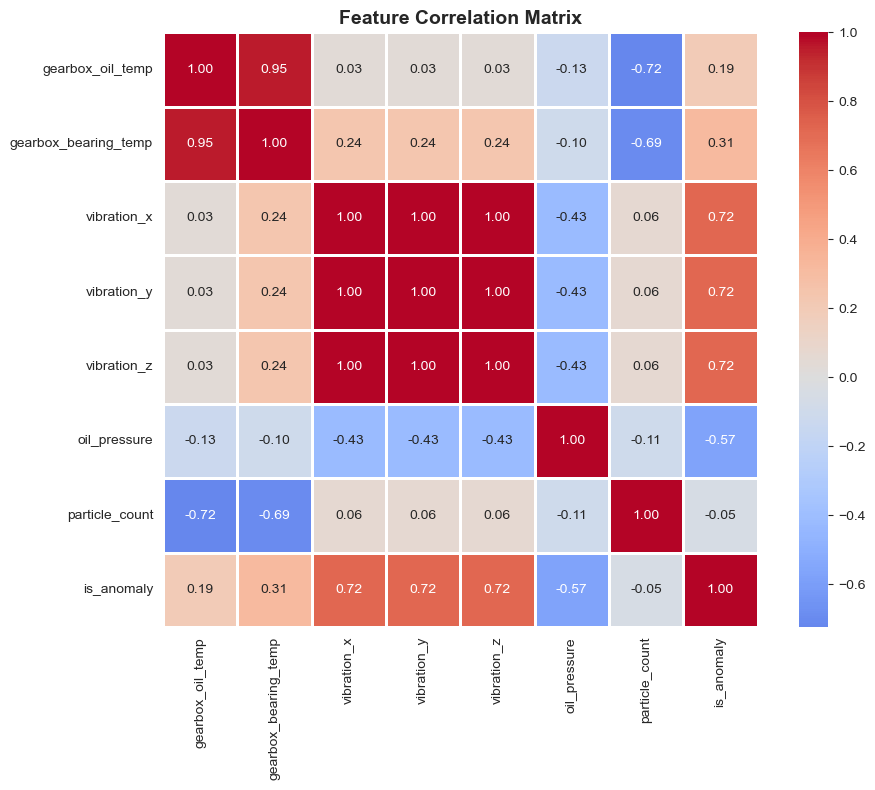

In [20]:
numeric_cols = feature_cols + ['is_anomaly']
correlation_matrix = df[numeric_cols].corr()

print("\nCorrelation with is_anomaly:")
print(correlation_matrix['is_anomaly'].sort_values(ascending=False))

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Feature Correlation Matrix', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()


### 7. Vibration Magnitude Analysis


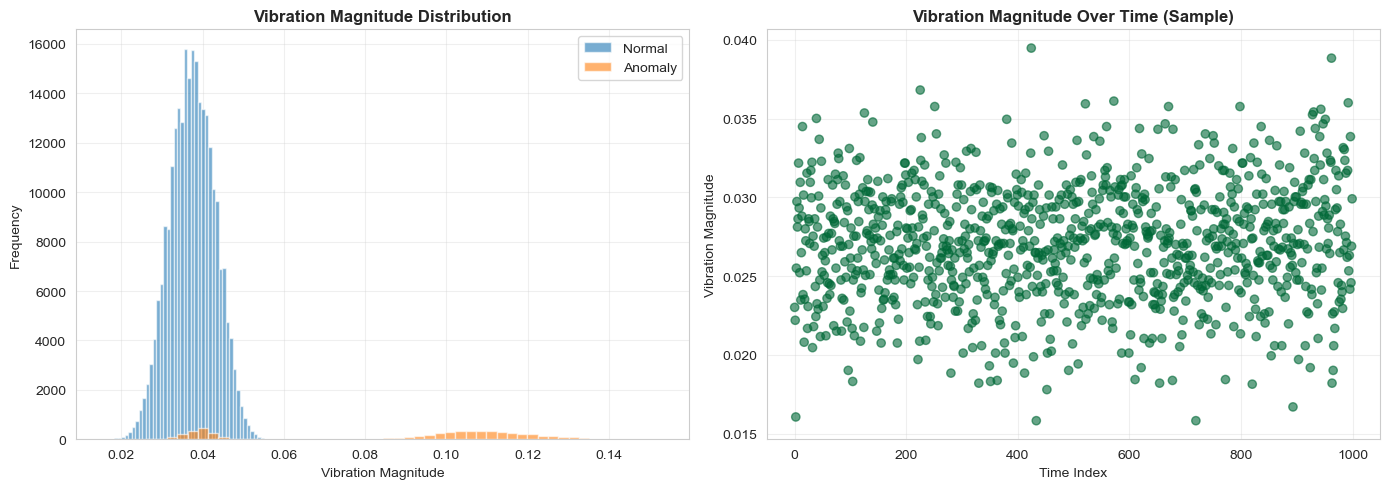

In [21]:
# Calculate total vibration magnitude
df['vibration_magnitude'] = np.sqrt(df['vibration_x']**2 + df['vibration_y']**2 + df['vibration_z']**2)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution by class
axes[0].hist(df[df['is_anomaly'] == 0]['vibration_magnitude'], bins=50, alpha=0.6, label='Normal')
axes[0].hist(df[df['is_anomaly'] == 1]['vibration_magnitude'], bins=50, alpha=0.6, label='Anomaly')
axes[0].set_xlabel('Vibration Magnitude')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Vibration Magnitude Distribution', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Time series plot (first 1000 points)
sample_df = df.head(1000)
axes[1].scatter(range(len(sample_df)), sample_df['vibration_magnitude'],
               c=sample_df['is_anomaly'], cmap='RdYlGn_r', alpha=0.6)
axes[1].set_xlabel('Time Index')
axes[1].set_ylabel('Vibration Magnitude')
axes[1].set_title('Vibration Magnitude Over Time (Sample)', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 8. Data Quality Summary


In [22]:
print(f"Total Records: {len(df):,}")
print(f"Normal Cases: {(df['is_anomaly'] == 0).sum():,} ({(df['is_anomaly'] == 0).sum()/len(df)*100:.1f}%)")
print(f"Anomaly Cases: {(df['is_anomaly'] == 1).sum():,} ({(df['is_anomaly'] == 1).sum()/len(df)*100:.1f}%)")
print(f"\nImbalance Ratio: {(df['is_anomaly'] == 0).sum() / (df['is_anomaly'] == 1).sum():.1f}:1")
print(f"\nMissing Values: {df.isnull().sum().sum()}")
print(f"Duplicate Rows: {df.duplicated().sum()}")
print(f"\nDataset is ready for modeling! ✓")


Total Records: 262,800
Normal Cases: 257,300 (97.9%)
Anomaly Cases: 5,500 (2.1%)

Imbalance Ratio: 46.8:1

Missing Values: 0
Duplicate Rows: 0

Dataset is ready for modeling! ✓
